In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from survlimepy import SurvLimeExplainer
from survlimepy.load_datasets import RandomSurvivalData
import pandas as pd
from pycox.models import DeepHitSingle, CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt
import seaborn as sns

In [ ]:
# Generate data for the first cluster
n_points_1 = 1000
true_coef_1 = [10**(-6), 0.1, -0.15, 10**(-6), 10**(-6)]
r_1 = 8
center_1 = [0, 0, 0, 0, 0]
prob_event_1 = 0.9
lambda_weibull_1 = 10**(-5)
v_weibull_1 = 2
n_features_1 = len(true_coef_1)

rsd_1 = RandomSurvivalData(
    center=center_1,
    radius=r_1,
    coefficients=true_coef_1,
    prob_event=prob_event_1,
    lambda_weibull=lambda_weibull_1,
    v_weibull=v_weibull_1,
    time_cap=2000,
    random_seed=90,
)

X_1, time_to_event_1, delta_1 = rsd_1.random_survival_data(num_points=n_points_1)

In [29]:

# Train test split for the first cluster
n_train_1 = 900
np.random.seed(90)
all_idx_1 = np.arange(X_1.shape[0])
idx_train_1 = np.random.choice(a=all_idx_1, size=n_train_1, replace=False)
idx_test_1 = [i for i in all_idx_1 if i not in idx_train_1]
X_train_1 = X_1[idx_train_1, :]
X_test_1 = X_1[idx_test_1, :]
time_to_event_train_1 = [time_to_event_1[i] for i in idx_train_1]
time_to_event_test_1 = [time_to_event_1[i] for i in idx_test_1]
delta_train_1 = [delta_1[i] for i in idx_train_1]
delta_test_1 = [delta_1[i] for i in idx_test_1]
z_train_1 = [(d, t) for d, t in zip(delta_train_1, time_to_event_train_1)]
y_train_1 = np.array(z_train_1, dtype=[("delta", np.bool_), ("time_to_event", np.float32)])

In [30]:
# Transform the data in order to have the DeepHit format
X_transformed_train = X_train_1.astype('float32')
X_transformed_test = X_test_1.astype('float32')

In [32]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
cox = CoxPHSurvivalAnalysis(alpha=0.0005)
cox.fit(X_transformed_train,y_train_1)

z_test_1 = [(d, t) for d, t in zip(delta_test_1, time_to_event_test_1)]
y_test_1 = np.array(z_test_1, dtype=[("delta", np.bool_), ("time_to_event", np.float32)]) 
cox.score(X_transformed_test, y_test_1)

0.6817454877770163

In [ ]:
get_target = lambda df: (df['duration'].values, df['event'].values)

In [ ]:
y_df_train = pd.DataFrame(data={'duration': time_to_event_train_1, 'event': delta_train_1})
y_deepsurv_train = get_target(y_df_train)

In [ ]:
y_df_test = pd.DataFrame(data={'duration': time_to_event_test_1, 'event': delta_test_1})
durations_test, events_test = get_target(y_df_test)

In [ ]:
in_features = X_transformed_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
output_bias = False
batch_size = 256
epochs = 512

In [ ]:
net_deep_surv = tt.practical.MLPVanilla(in_features, num_nodes, 1, batch_norm,dropout, output_bias=output_bias)
deep_surv = CoxPH(net_deep_surv, tt.optim.Adam())
deep_surv.optimizer.set_lr(0.001)
log = deep_surv.fit(
    input=X_transformed_train,
    target=y_deepsurv_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)

In [ ]:
deep_surv.compute_baseline_hazards()

duration
2.204481       0.000805
12.782281      0.000807
14.982987      0.000808
15.937723      0.000000
19.528277      0.000811
                 ...   
882.193154     0.757519
910.560225     0.960525
990.689093     1.313143
1091.135661    2.541550
1110.080583    4.821452
Name: baseline_hazards, Length: 900, dtype: float64

In [ ]:
predictions = deep_surv.predict_surv_df(X_transformed_test)

In [ ]:
ev = EvalSurv(predictions, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td()

0.6687228695453507

In [ ]:
def create_chf(fun):
    def inner(X):
        Y = fun(X)
        return Y.T
    return inner

predict_chf = create_chf(deep_surv.predict_cumulative_hazards)

In [ ]:
X_test_1[0]

array([-3.0509382 ,  1.9318789 , -1.3668663 ,  5.70106743,  1.34279557])

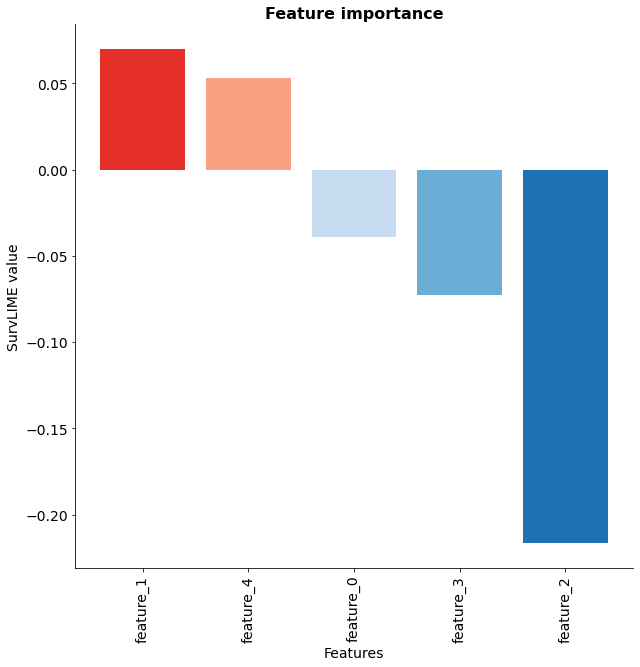

In [ ]:
explainer_deepsurv = SurvLimeExplainer(
    training_features=X_transformed_test,
    training_events=delta_test_1,
    training_times=time_to_event_test_1,
    model_output_times=np.sort(np.unique(time_to_event_train_1)),
    random_state=10,
)

b_deepsurv = explainer_deepsurv.explain_instance(
    data_row=X_test_1[0],
    predict_fn=predict_chf,
    num_samples=1000,
    verbose=False,
)

explainer_deepsurv.plot_weights()

In [ ]:
true_coef_1 = [10**(-6), 0.1, -0.15, 10**(-6), 10**(-6)]

In [ ]:
explainer_deepsurv = SurvLimeExplainer(
    training_features=X_transformed_test,
    training_events=delta_test_1,
    training_times=time_to_event_test_1,
    model_output_times=np.sort(np.unique(time_to_event_train_1)),
    random_state=10,
)

b_deepsurv = explainer_deepsurv.montecarlo_explanation(
    data=X_test_1[:10],
    predict_fn=predict_chf,
    num_samples=1000,
    verbose=False,
)

In [ ]:
explainer_deepsurv.plot_montecarlo_weights(feature_names=["one", "two", "three", "four", "five"])

In [ ]:
b_deepsurv

one     -0.000941
two      0.070189
three   -0.111271
four    -0.006609
five    -0.003426
dtype: float64


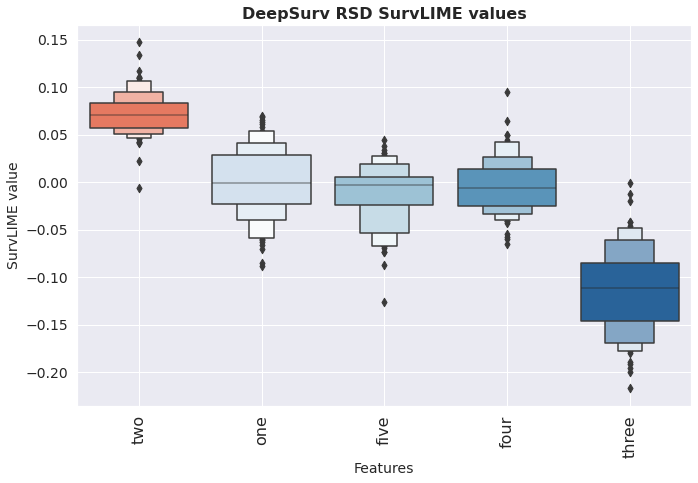

In [3]:

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp_deepsurv_rds/'
models= ['deepsurv']
for model_type in models:
    data = pd.read_csv(w_path+f'exp_deepsurv_rds_surv_weights_100.csv')
    #data_2 = pd.read_csv(w_path+f'exp_deepsurv_rds_surv_weights_2.csv')
 #   import ipdb;ipdb.set_trace()
   # data = pd.concat([data, data_2], axis=0)
    median_up = {}
    median_down = {}
    threshold = 0
    print(data.median())
    for (columnName, columnData) in data.items():
        median_value = np.median(columnData)
        if median_value > threshold:
            median_up[columnName] = median_value
        else:
            median_down[columnName] = median_value

    median_up = dict(
        sorted(median_up.items(), key=lambda item: item[1], reverse=True)
    )
    median_down = dict(
        sorted(median_down.items(), key=lambda item: item[1], reverse=True)
    )

    pal_up = sns.color_palette("Reds_r", n_colors=len(median_up))
    pal_down = sns.color_palette("Blues", n_colors=len(median_down))
    colors_up = {key: val for key, val in zip(median_up.keys(), pal_up)}
    colors_down = {key: val for key, val in zip(median_down.keys(), pal_down)}
    custom_pal = {**colors_up, **colors_down}
    data_reindex = data.reindex(columns=custom_pal.keys())
    data_melt = pd.melt(data_reindex)

    _, ax = plt.subplots(figsize=(11,7))
    ax.tick_params(labelrotation=90)
    p = sns.boxenplot(
        x="variable",
        y="value",
        data=data_melt,
        palette=custom_pal,
        ax=ax,
    )

    p.set_xlabel('Features', fontsize= 14)
    p.set_ylabel('SurvLIME value', fontsize= 14)
    p.yaxis.grid(True)
    p.xaxis.grid(True)

    p.set_title(f'DeepSurv RSD SurvLIME values', fontsize= 16, fontweight='bold');


    plt.xticks(fontsize=16, rotation=90)
    plt.yticks(fontsize=14, rotation=0)

#    plt.savefig(f'/home/carlos.hernandez/PhD/survlime-paper/notebooks/figures/final_figures/deepsurv_rds_montecarlo.png',  bbox_inches='tight', dpi=200)


In [2]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from math import sqrt
import scipy as sp

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sksurv.metrics import concordance_index_censored



<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject
